# Rede Neural de Base Radial (RBF)

1ª Etapa: Inicialização dos grupos com K-Means

In [0]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


def kmeans_std(X, k):

    stds = np.zeros(k)
  
    kmeans = KMeans(n_clusters = 2, init = 'random')
    kmeans.fit(X)
    
    clusters = kmeans.cluster_centers_
    distances = kmeans.fit_transform(X)
    print(distances)
    
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])

    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    
    return clusters, stds

Definição da função de base radial

In [0]:
def rbfGaussiana(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2) # e**-((E*r)**2)
  
def rbfMultiquadrada(x, c, s):
    return np.sqrt( ((x-c)**2) + (c**2)) / c

def rbfMultiquadrada_inversa(x, c, s):
    return c / np.sqrt( ((x-c)**2) + (c**2))

2ª Etapa - Treinamento de uma Rede Neural

In [0]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=[rbfGaussiana,rbfMultiquadrada,
                                                      rbfMultiquadrada_inversa], inferStds=True):
        self.k = k #grupos
        self.lr = lr 
        self.epochs = epochs #número de iterações
        self.rbf = rbf
        self.inferStds = inferStds #se vai calcular o tamanho do cluster (std)

        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans_std(X,self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans_std(X,self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        
        
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                loss = (y[i] - F).flatten() ** 2
                #print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                
                lae = np.dot(self.lr, np.dot(a, error))
                
                self.w = np.subtract(self.w, lae)
                self.b = self.b - self.lr * error

    def predict(self, X):
        y_pred = []
        error = 0
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
            
            
        return np.array(y_pred)



# Executando com Base de Dados

[[0.8433899  3.01916466]
 [2.77588824 1.25062864]
 [1.42451069 3.03437208]
 ...
 [2.18688907 3.14152664]
 [1.56039865 3.57972   ]
 [0.95261667 2.77510944]]
error:  0.011436400148761057


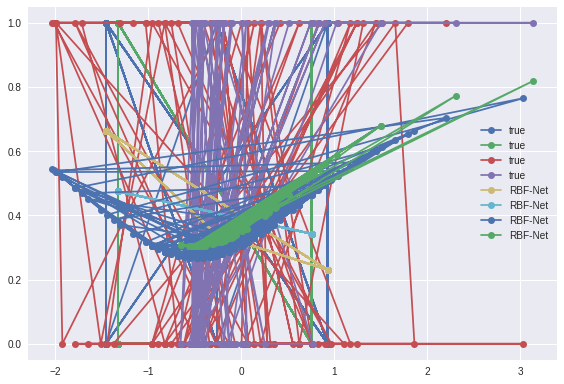

[[3.01916466 0.8433899 ]
 [1.25062864 2.77588824]
 [3.03437208 1.42451069]
 ...
 [3.14152664 2.18688907]
 [3.57972    1.56039865]
 [2.77510944 0.95261667]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract


error:  nan


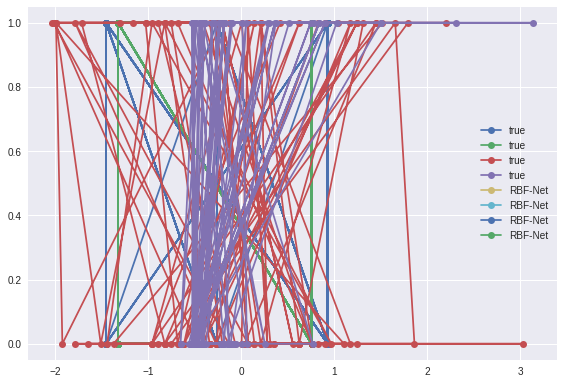

[[0.8433899  3.01916466]
 [2.77588824 1.25062864]
 [1.42451069 3.03437208]
 ...
 [2.18688907 3.14152664]
 [1.56039865 3.57972   ]
 [0.95261667 2.77510944]]
error:  0.015822551687787678


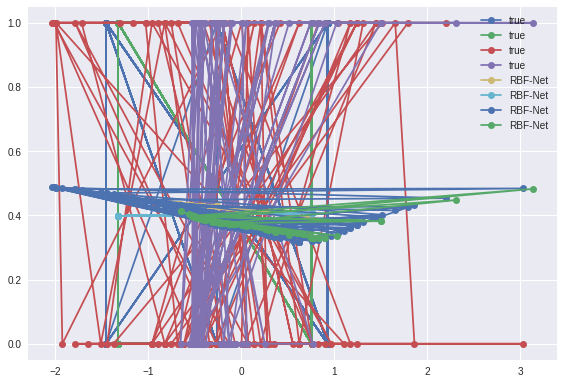

In [44]:
data = 'train-mod.csv'
sigma = 1.2
itergd = 300


dataread = np.genfromtxt(data, delimiter=',')[1:,1:]

alldata = []
for i in range(len(dataread)):
    if np.isnan(dataread[i,-2]):
		    continue
    alldata.append(dataread[i])

alldata = np.asarray(alldata)

#dividing data
trainparam = alldata[:600,1:]
trainlabel = alldata[:600,0]

testparam = alldata[600:,1:]
testlabel = alldata[600:,0]

###############
#normalization#
###############

std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
    std[i] = np.std(trainparam[:,i])
    rata[i] = np.mean(trainparam[:,i])
    trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
    testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]
    
rbfnet = RBFNet(lr=1e-2, k=2, rbf=rbfGaussiana, inferStds=True)
rbfnet2 = RBFNet(lr=1e-2, k=2, rbf=rbfMultiquadrada, inferStds=True)
rbfnet3 = RBFNet(lr=1e-2, k=2, rbf=rbfMultiquadrada_inversa, inferStds=True)

###
rbfnet.fit(trainparamnorm, trainlabel)

y_pred = rbfnet.predict(testparamnorm)

y = testlabel[:,None]

yYpred = np.subtract(y, y_pred)

errorabs = abs(yYpred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))

plt.plot(testparamnorm, y, '-o', label='true')
plt.plot(testparamnorm, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

### Multiquadrada

rbfnet2.fit(trainparamnorm, trainlabel)

y_pred = rbfnet2.predict(testparamnorm)

y = testlabel[:,None]

yYpred = np.subtract(y, y_pred)

errorabs = abs(yYpred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))

plt.plot(testparamnorm, y, '-o', label='true')
plt.plot(testparamnorm, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

### Multiquadrada_inversa

rbfnet3.fit(trainparamnorm, trainlabel)

y_pred = rbfnet3.predict(testparamnorm)

y = testlabel[:,None]

yYpred = np.subtract(y, y_pred)

errorabs = abs(yYpred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))

plt.plot(testparamnorm, y, '-o', label='true')
plt.plot(testparamnorm, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()



# Descrição Mini Projeto

Utilizando o código acima, modifique a última seção (Executando com Base de Dados) para que ele seja executado com a base de dados do arquivo train-mod.csv. Depois, modifique a função de base radial implementada (Gaussiana), para a Multiquadrática e a Multiquadrática Inversa e calcule a taxa de erro.

1 - Calcular o taxa de erro no conjunto de teste na RBF utilizando a base de dados train-mod.csv

2- Calcular a taxa de erro usando 3 funções de Base Radial:
a) Gaussiana
b) Multiquadrática
c) Multiquadrática Inversa


DATA DE ENTREGA: 02/04/2019
